In [23]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.base import BaseEstimator, ClassifierMixin
import textwrap
import pickle

In [24]:
# Choose which days to include
#day_list = ['20181105', '20181102', '20181101']

# Or, read in list of days from txt file
day_list = list()
with open(f'data/combined/days.txt', 'r') as file:
    for line in file:
        day_list.append(line.strip())

num_sess = len(day_list)
num_goals = 6
tbin_size = 0.1

In [25]:
good_cell_labels = list()
with open('data/cell_list_hm.txt', 'r') as file:
    for line in file:
        line = line.strip().split('/')
        good_cell_labels.append(f'{line[5]}ch{str(int(line[8][7:]))}c{str(int(line[9][4:]))}')
print(good_cell_labels)

['20181105ch29c1', '20181105ch30c1', '20181105ch43c1', '20181105ch43c2', '20181105ch43c3', '20181105ch45c1', '20181102ch9c1', '20181102ch19c1', '20181102ch19c2', '20181102ch26c1', '20181102ch26c2', '20181102ch29c1', '20181102ch30c1', '20181102ch30c2', '20181102ch31c1', '20181102ch43c1', '20181102ch43c2', '20181102ch45c1', '20181102ch45c2', '20181101ch19c1', '20181101ch19c2', '20181101ch21c1', '20181101ch23c1', '20181101ch29c1', '20181101ch29c2', '20181101ch29c3', '20181101ch29c4', '20181101ch30c1', '20181101ch30c2', '20181101ch35c1', '20181101ch43c1', '20181101ch45c1', '20181031ch19c1', '20181031ch19c2', '20181031ch19c3', '20181031ch26c1', '20181031ch26c2', '20181031ch29c1', '20181031ch30c1', '20181031ch30c2', '20181031ch35c1', '20181031ch35c2', '20181031ch35c3', '20181031ch43c1', '20181031ch43c2', '20181031ch45c1', '20181031ch45c2', '20181026ch19c1', '20181026ch19c2', '20181026ch19c3', '20181026ch29c1', '20181026ch30c1', '20181026ch35c1', '20181026ch35c2', '20181026ch35c3', '20181026c

In [26]:
# Save directory for data files
prefix = "/Volumes/Hippocampus/Data/picasso-misc/"
save_dir = "data/placedist"
# Whether to overwrite preexisting files
overwrite = True

In [27]:
#Read placeist files
all_place_responses = list()
all_place_durations = list()
all_cell_labels = list()

for day in day_list:
    with open(f'{save_dir}/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        num_sess_cells = len(data['cell_labels'])
        all_place_responses.extend(data['place_responses_per_cell'])
        for _ in range(num_sess_cells):
            all_place_durations.append(data['durations_per_place'])
        all_cell_labels.extend(data['cell_labels'])

In [28]:
del all_place_durations
del all_place_responses

In [29]:
new_list_labels = list()
for cell_label in all_cell_labels:
    if cell_label in good_cell_labels:
        new_list_labels.append(cell_label)
print(len(new_list_labels))

364


In [30]:
# Set amount of bins, see which cells are valid for testing 
total_bins = 23
two_thirds = 16
valid_cells_distribution = list()

for day in day_list:
    with open(f'{save_dir}/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        place_responses_per_cell = data['place_responses_per_cell']
        cell_labels = data['cell_labels']
    for cell, label in enumerate(cell_labels):
        if label not in good_cell_labels:
            continue
        total_valid_bins = list()
        # if 2/3 of the bins contain over 30 samples, the cell is valid
        for bin, dist in place_responses_per_cell[cell].items():
            dist = dist[dist > 0]
            if dist.size > 5:
                total_valid_bins.append(bin)

        if len(total_valid_bins) > two_thirds:
            valid_cells_distribution.append(label)
print('Amount of valid cells:', len(valid_cells_distribution))
train_size = int(round((len(valid_cells_distribution) * 0.7),0))
test_size = int(round((len(valid_cells_distribution) * 0.3),0))
print(train_size)
print(test_size)
print(valid_cells_distribution)
list_nums = list(range(1,(len(valid_cells_distribution) + 1)))
valid_cell_to_num = dict(zip(valid_cells_distribution, list_nums))
print(valid_cell_to_num)


Amount of valid cells: 296
207
89
['20181105ch29c1', '20181105ch30c1', '20181105ch43c1', '20181105ch43c3', '20181105ch45c1', '20181102ch9c1', '20181102ch19c1', '20181102ch26c2', '20181102ch29c1', '20181102ch30c1', '20181102ch30c2', '20181102ch31c1', '20181102ch43c1', '20181102ch43c2', '20181101ch19c1', '20181101ch19c2', '20181101ch21c1', '20181101ch23c1', '20181101ch29c2', '20181101ch29c3', '20181101ch29c4', '20181101ch30c2', '20181101ch35c1', '20181101ch43c1', '20181031ch19c2', '20181031ch26c1', '20181031ch26c2', '20181031ch29c1', '20181031ch30c1', '20181031ch43c1', '20181031ch43c2', '20181026ch19c1', '20181026ch29c1', '20181026ch30c1', '20181026ch35c1', '20181026ch35c2', '20181026ch45c1', '20181022ch9c1', '20181022ch26c1', '20181022ch29c1', '20181022ch43c1', '20181022ch43c2', '20181022ch43c4', '20181022ch45c1', '20181022ch93c1', '20181017ch29c1', '20181017ch45c1', '20181016ch20c1', '20181016ch29c1', '20181016ch45c1', '20181015ch6c1', '20181015ch20c1', '20181015ch29c1', '20181015ch45c

In [31]:
bins_data = {}
for day in day_list:
    with open(f'{save_dir}/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        place_responses_per_cell = data['place_responses_per_cell']
        cell_labels = data['cell_labels']
    for cell, label in enumerate(cell_labels):
        if label not in valid_cells_distribution:
            continue
        for bin, dist in place_responses_per_cell[cell].items():
            dist = dist[dist > 0]
            if bin not in bins_data:
                bins_data[bin] = []
            bins_data[bin].append(dist)


In [32]:
X = []
y = []
bin_list = [1,2,3,4,5,6,8,10,11,12,13,14,15,16,18,20,21,22,23,24,25]
for i in bin_list:
    temp_list = bins_data[i]
    X.extend(temp_list)
    y.extend([i] * len(bins_data[i]))


In [33]:
max_length = max(len(seq) for seq in X)
X_padded = pad_sequences(X, maxlen=max_length, padding='post', dtype='float32')
y = np.asarray(y)
    

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
accuracy_random_forst = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")

Accuracy: 0.20739549839228297
Classification Report:
              precision    recall  f1-score   support

           1       0.21      0.26      0.23        70
           2       0.10      0.08      0.09        71
           3       0.04      0.04      0.04        52
           4       0.22      0.26      0.24        61
           5       0.19      0.26      0.22        62
           6       0.21      0.19      0.20        64
           8       0.20      0.19      0.20        47
          10       0.12      0.11      0.12        73
          11       0.21      0.14      0.17        65
          12       0.24      0.21      0.23        57
          13       0.75      0.73      0.74        49
          14       0.36      0.32      0.34        50
          15       0.29      0.25      0.27        55
          16       0.12      0.17      0.14        52
          18       0.18      0.14      0.16        56
          20       0.12      0.15      0.13        54
          21       0.23     

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
mse_random_forest_regressor = mean_squared_error(y_test, y_pred)


Mean Squared Error: 60.876101771664906


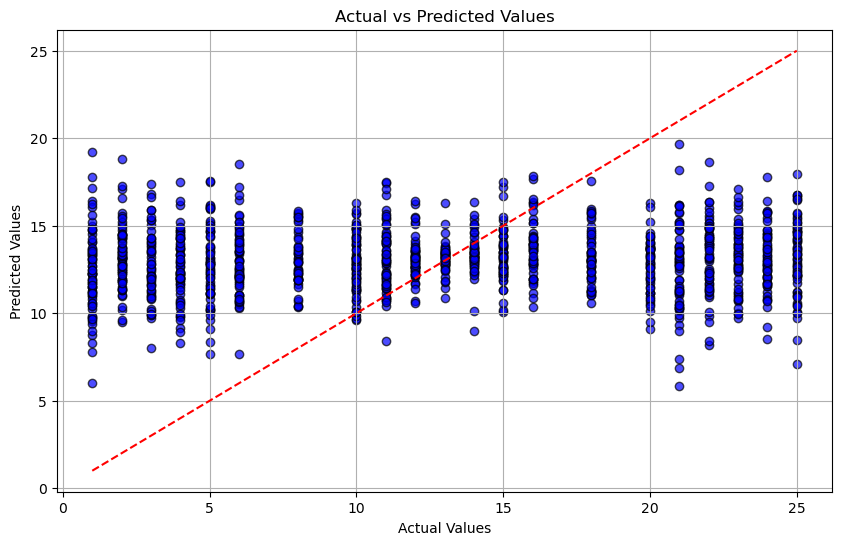

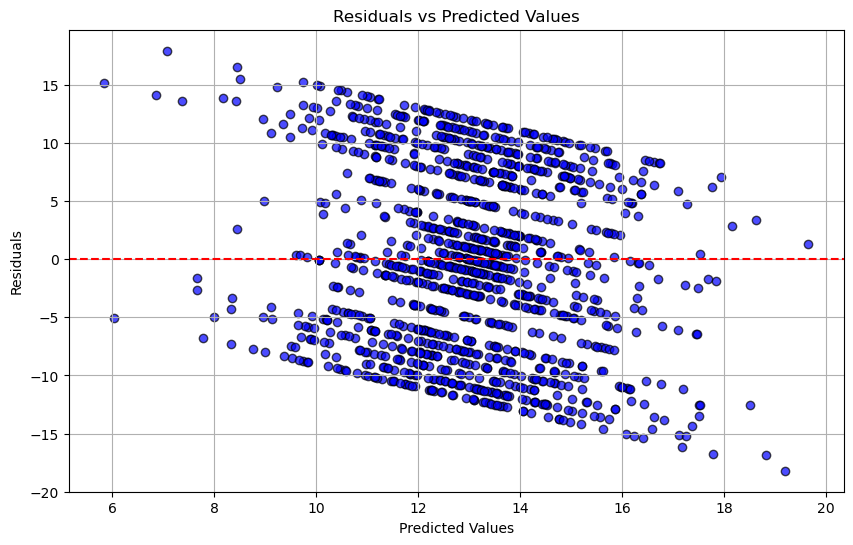

In [36]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.show()

residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue', edgecolor='k', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.base import BaseEstimator, ClassifierMixin
import textwrap
import pickle

In [ ]:
# Choose which days to include
#day_list = ['20181105', '20181102', '20181101']

# Or, read in list of days from txt file
day_list = list()
with open(f'data/combined/days.txt', 'r') as file:
    for line in file:
        day_list.append(line.strip())

num_sess = len(day_list)
num_goals = 6
tbin_size = 0.1

In [ ]:
good_cell_labels = list()
with open('data/cell_list_hm.txt', 'r') as file:
    for line in file:
        line = line.strip().split('/')
        good_cell_labels.append(f'{line[5]}ch{str(int(line[8][7:]))}c{str(int(line[9][4:]))}')
print(good_cell_labels)

['20181105ch29c1', '20181105ch30c1', '20181105ch43c1', '20181105ch43c2', '20181105ch43c3', '20181105ch45c1', '20181102ch9c1', '20181102ch19c1', '20181102ch19c2', '20181102ch26c1', '20181102ch26c2', '20181102ch29c1', '20181102ch30c1', '20181102ch30c2', '20181102ch31c1', '20181102ch43c1', '20181102ch43c2', '20181102ch45c1', '20181102ch45c2', '20181101ch19c1', '20181101ch19c2', '20181101ch21c1', '20181101ch23c1', '20181101ch29c1', '20181101ch29c2', '20181101ch29c3', '20181101ch29c4', '20181101ch30c1', '20181101ch30c2', '20181101ch35c1', '20181101ch43c1', '20181101ch45c1', '20181031ch19c1', '20181031ch19c2', '20181031ch19c3', '20181031ch26c1', '20181031ch26c2', '20181031ch29c1', '20181031ch30c1', '20181031ch30c2', '20181031ch35c1', '20181031ch35c2', '20181031ch35c3', '20181031ch43c1', '20181031ch43c2', '20181031ch45c1', '20181031ch45c2', '20181026ch19c1', '20181026ch19c2', '20181026ch19c3', '20181026ch29c1', '20181026ch30c1', '20181026ch35c1', '20181026ch35c2', '20181026ch35c3', '20181026c

In [ ]:
# Save directory for data files
prefix = "/Volumes/Hippocampus/Data/picasso-misc/"
save_dir = "data/placedist"
# Whether to overwrite preexisting files
overwrite = True

In [ ]:
#Read placeist files
all_place_responses = list()
all_place_durations = list()
all_cell_labels = list()

for day in day_list:
    with open(f'{save_dir}/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        num_sess_cells = len(data['cell_labels'])
        all_place_responses.extend(data['place_responses_per_cell'])
        for _ in range(num_sess_cells):
            all_place_durations.append(data['durations_per_place'])
        all_cell_labels.extend(data['cell_labels'])

In [ ]:
del all_place_durations
del all_place_responses

In [ ]:
new_list_labels = list()
for cell_label in all_cell_labels:
    if cell_label in good_cell_labels:
        new_list_labels.append(cell_label)
print(len(new_list_labels))

364


In [ ]:
# Set amount of bins, see which cells are valid for testing 
total_bins = 23
two_thirds = 16
valid_cells_distribution = list()

for day in day_list:
    with open(f'{save_dir}/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        place_responses_per_cell = data['place_responses_per_cell']
        cell_labels = data['cell_labels']
    for cell, label in enumerate(cell_labels):
        if label not in good_cell_labels:
            continue
        total_valid_bins = list()
        # if 2/3 of the bins contain over 30 samples, the cell is valid
        for bin, dist in place_responses_per_cell[cell].items():
            dist = dist[dist > 0]
            if dist.size > 5:
                total_valid_bins.append(bin)

        if len(total_valid_bins) > two_thirds:
            valid_cells_distribution.append(label)
print('Amount of valid cells:', len(valid_cells_distribution))
train_size = int(round((len(valid_cells_distribution) * 0.7),0))
test_size = int(round((len(valid_cells_distribution) * 0.3),0))
print(train_size)
print(test_size)
print(valid_cells_distribution)
list_nums = list(range(1,(len(valid_cells_distribution) + 1)))
valid_cell_to_num = dict(zip(valid_cells_distribution, list_nums))
print(valid_cell_to_num)


Amount of valid cells: 296
207
89
['20181105ch29c1', '20181105ch30c1', '20181105ch43c1', '20181105ch43c3', '20181105ch45c1', '20181102ch9c1', '20181102ch19c1', '20181102ch26c2', '20181102ch29c1', '20181102ch30c1', '20181102ch30c2', '20181102ch31c1', '20181102ch43c1', '20181102ch43c2', '20181101ch19c1', '20181101ch19c2', '20181101ch21c1', '20181101ch23c1', '20181101ch29c2', '20181101ch29c3', '20181101ch29c4', '20181101ch30c2', '20181101ch35c1', '20181101ch43c1', '20181031ch19c2', '20181031ch26c1', '20181031ch26c2', '20181031ch29c1', '20181031ch30c1', '20181031ch43c1', '20181031ch43c2', '20181026ch19c1', '20181026ch29c1', '20181026ch30c1', '20181026ch35c1', '20181026ch35c2', '20181026ch45c1', '20181022ch9c1', '20181022ch26c1', '20181022ch29c1', '20181022ch43c1', '20181022ch43c2', '20181022ch43c4', '20181022ch45c1', '20181022ch93c1', '20181017ch29c1', '20181017ch45c1', '20181016ch20c1', '20181016ch29c1', '20181016ch45c1', '20181015ch6c1', '20181015ch20c1', '20181015ch29c1', '20181015ch45c

In [ ]:
bins_data = {}
for day in day_list:
    with open(f'{save_dir}/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        place_responses_per_cell = data['place_responses_per_cell']
        cell_labels = data['cell_labels']
    for cell, label in enumerate(cell_labels):
        if label not in valid_cells_distribution:
            continue
        for bin, dist in place_responses_per_cell[cell].items():
            dist = dist[dist > 0]
            if bin not in bins_data:
                bins_data[bin] = []
            bins_data[bin].append(dist)


In [ ]:
X = []
y = []
bin_list = [1,2,3,4,5,6,8,10,11,12,13,14,15,16,18,20,21,22,23,24,25]
for i in bin_list:
    temp_list = bins_data[i]
    X.extend(temp_list)
    y.extend([i] * len(bins_data[i]))


In [ ]:
max_length = max(len(seq) for seq in X)
X_padded = pad_sequences(X, maxlen=max_length, padding='post', dtype='float32')
y = np.asarray(y)
    

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
accuracy_random_forst = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")

Accuracy: 0.20739549839228297
Classification Report:
              precision    recall  f1-score   support

           1       0.21      0.26      0.23        70
           2       0.10      0.08      0.09        71
           3       0.04      0.04      0.04        52
           4       0.22      0.26      0.24        61
           5       0.19      0.26      0.22        62
           6       0.21      0.19      0.20        64
           8       0.20      0.19      0.20        47
          10       0.12      0.11      0.12        73
          11       0.21      0.14      0.17        65
          12       0.24      0.21      0.23        57
          13       0.75      0.73      0.74        49
          14       0.36      0.32      0.34        50
          15       0.29      0.25      0.27        55
          16       0.12      0.17      0.14        52
          18       0.18      0.14      0.16        56
          20       0.12      0.15      0.13        54
          21       0.23     

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
mse_random_forest_regressor = mean_squared_error(y_test, y_pred)


Mean Squared Error: 60.876101771664906


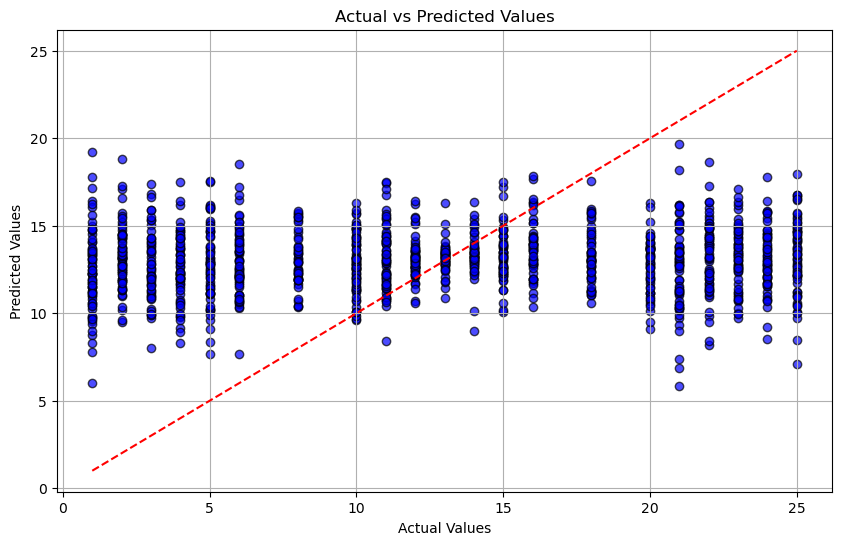

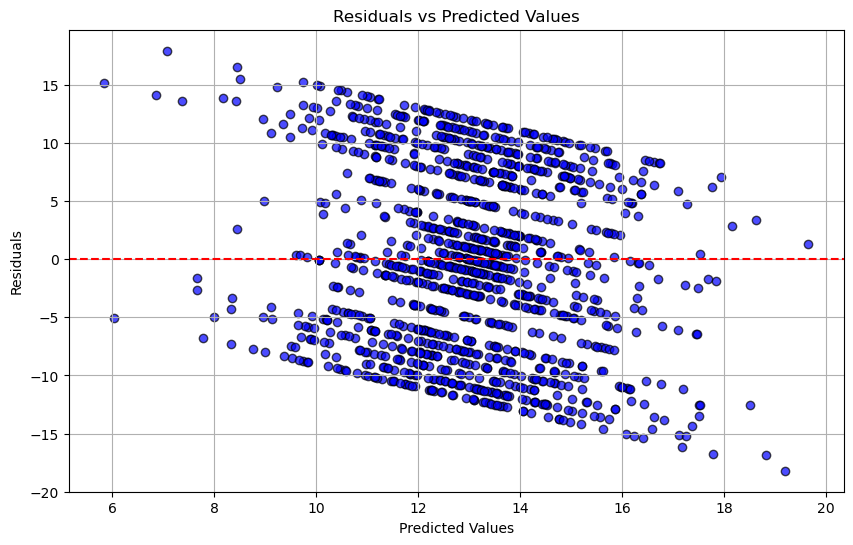

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.show()

residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue', edgecolor='k', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_decision_tree_classifier = accuracy_score(y_test, y_pred)
print(accuracy_decision_tree_classifier)
eport = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")

0.16157556270096463
Classification Report:
              precision    recall  f1-score   support

           1       0.21      0.26      0.23        70
           2       0.10      0.08      0.09        71
           3       0.04      0.04      0.04        52
           4       0.22      0.26      0.24        61
           5       0.19      0.26      0.22        62
           6       0.21      0.19      0.20        64
           8       0.20      0.19      0.20        47
          10       0.12      0.11      0.12        73
          11       0.21      0.14      0.17        65
          12       0.24      0.21      0.23        57
          13       0.75      0.73      0.74        49
          14       0.36      0.32      0.34        50
          15       0.29      0.25      0.27        55
          16       0.12      0.17      0.14        52
          18       0.18      0.14      0.16        56
          20       0.12      0.15      0.13        54
          21       0.23      0.30     

In [ ]:
model = SVC(kernel='linear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")
print()

model = SVC(kernel='poly')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")
print()

model = SVC(kernel='rbf')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")
print()

model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")
print()

Accuracy Score: 0.13745980707395497
Classification Report:
              precision    recall  f1-score   support

           1       0.16      0.23      0.19        70
           2       0.09      0.08      0.09        71
           3       0.05      0.08      0.06        52
           4       0.07      0.05      0.06        61
           5       0.12      0.15      0.13        62
           6       0.09      0.06      0.07        64
           8       0.12      0.15      0.13        47
          10       0.17      0.14      0.15        73
          11       0.15      0.15      0.15        65
          12       0.32      0.32      0.32        57
          13       0.29      0.31      0.30        49
          14       0.28      0.26      0.27        50
          15       0.08      0.09      0.09        55
          16       0.05      0.06      0.05        52
          18       0.11      0.09      0.10        56
          20       0.13      0.11      0.12        54
          21       0.1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.22, random_state=42)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.11476608187134503
Classification Report:
              precision    recall  f1-score   support

           1       0.15      0.24      0.19        76
           2       0.06      0.07      0.06        76
           3       0.07      0.08      0.07        61
           4       0.13      0.10      0.11        70
           5       0.11      0.18      0.14        67
           6       0.04      0.04      0.04        67
           8       0.03      0.02      0.02        55
          10       0.17      0.10      0.13        77
          11       0.14      0.09      0.11        68
          12       0.28      0.11      0.15        66
          13       0.38      0.22      0.28        54
          14       0.36      0.18      0.24        55
          15       0.06      0.03      0.04        60
          16       0.09      0.17      0.12        60
          18       0.08      0.05      0.06        64
          20       0.10      0.07      0.08        57
          21       0.13     

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
svm = SVC(kernel='linear', probability=True, random_state=42)
dt = DecisionTreeClassifier(random_state=42)
lda = LinearDiscriminantAnalysis()

models = {
    'Random Forest': rf,
    'SVM': svm,
    'Decision Tree': dt,
    'LDA': lda
}

rf.fit(X_train, y_train)
svm.fit(X_train, y_train)
dt.fit(X_train, y_train)
lda.fit(X_train, y_train)

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy}")
    print(f"{name} Classification Report:\n{classification_report(y_test, y_pred)}")

Random Forest Accuracy: 0.20739549839228297
Random Forest Classification Report:
              precision    recall  f1-score   support

           1       0.21      0.26      0.23        70
           2       0.10      0.08      0.09        71
           3       0.04      0.04      0.04        52
           4       0.22      0.26      0.24        61
           5       0.19      0.26      0.22        62
           6       0.21      0.19      0.20        64
           8       0.20      0.19      0.20        47
          10       0.12      0.11      0.12        73
          11       0.21      0.14      0.17        65
          12       0.24      0.21      0.23        57
          13       0.75      0.73      0.74        49
          14       0.36      0.32      0.34        50
          15       0.29      0.25      0.27        55
          16       0.12      0.17      0.14        52
          18       0.18      0.14      0.16        56
          20       0.12      0.15      0.13        54


In [ ]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[
    ('rf', rf),
    ('svm', svm),
    ('dt', dt),
], voting='soft')    
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Voting Classifier Accuracy: {accuracy}")
print(f"Voting Classifier Classification Report:\n{classification_report(y_test, y_pred)}")

Voting Classifier Accuracy: 0.1567524115755627
Voting Classifier Classification Report:
              precision    recall  f1-score   support

           1       0.19      0.16      0.17        70
           2       0.14      0.14      0.14        71
           3       0.09      0.10      0.09        52
           4       0.17      0.20      0.18        61
           5       0.19      0.21      0.20        62
           6       0.13      0.14      0.14        64
           8       0.14      0.15      0.14        47
          10       0.07      0.05      0.06        73
          11       0.09      0.09      0.09        65
          12       0.25      0.25      0.25        57
          13       0.42      0.55      0.47        49
          14       0.26      0.24      0.25        50
          15       0.19      0.18      0.18        55
          16       0.13      0.17      0.15        52
          18       0.11      0.11      0.11        56
          20       0.06      0.06      0.06    

In [ ]:
class CustomVotingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, estimators, class_weights):
        self.estimators = estimators
        self.class_weights = class_weights
        self.class_labels = None
    
    def fit(self, X, y):
        self.models_ = []
        for name, model in self.estimators:
            model.fit(X, y)
            self.models_.append(model)
        
        self.class_labels = np.unique(y)
        return self
    
    def predict(self, X):
        probas = np.zeros((X.shape[0], len(self.class_labels)))
        for model in self.models_:
            probas += model.predict_proba(X)
        
        weighted_probas = np.zeros_like(probas)
        for class_idx, class_label in enumerate(self.class_labels):
            for model_idx, model in enumerate(self.models_):
                class_index_in_probas = np.where(self.class_labels == class_label)[0][0]
                weighted_probas[:, class_idx] += probas[:, class_index_in_probas] * self.class_weights[class_label][model_idx]
        
        weighted_probas /= np.sum([weight for weights in self.class_weights.values() for weight in weights])
        
        return self.class_labels[np.argmax(weighted_probas, axis=1)]

In [ ]:
bin_list = [1,2,3,4,5,6,8,10,11,12,13,14,15,16,18,20,21,22,23,24,25]

estimators = [
    ('rf', rf),
    ('svm', svm),
    ('dt', dt),
    ('lda', lda)
]

class_weights = {
    1: [1.0, 1.0, 1.0, 1.0],
    2: [1.0, 0.5, 1.0, 0.0],
    3: [1.0, 0.75, 1.0, 0.1],
    4: [1.0, 0.8, 0.9, 0.8],
    5: [1.0, 1.0, 1.0, 1.0],
    6: [1.0, 1.0, 1.0, 1.0],
    8: [1.0, 1.0, 1.0, 1.0],
    10: [1.0, 1.0, 1.0, 1.0],
    11: [1.0, 1.0, 1.0, 1.0],
    12: [1.0, 1.0, 1.0, 1.0],
    13: [1.0, 1.0, 1.0, 1.0],
    14: [1.0, 1.0, 1.0, 1.0],
    15: [1.0, 1.0, 1.0, 1.0],
    16: [1.0, 1.0, 1.0, 1.0],
    18: [1.0, 1.0, 1.0, 1.0],
    20: [1.0, 1.0, 1.0, 1.0],
    21: [1.0, 1.0, 1.0, 1.0],
    22: [1.0, 1.0, 1.0, 1.0],
    23: [1.0, 1.0, 1.0, 1.0],
    24: [1.0, 1.0, 1.0, 1.0],
    25: [1.0, 1.0, 1.0, 1.0]
}
custom_voting_clf = CustomVotingClassifier(estimators=estimators, class_weights=class_weights)
custom_voting_clf.fit(X_train, y_train)

y_pred = custom_voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Custom Voting Classifier Accuracy: {accuracy}")
print(f"Custom Voting Classifier Classification Report:\n{classification_report(y_test, y_pred)}")

Custom Voting Classifier Accuracy: 0.15755627009646303
Custom Voting Classifier Classification Report:
              precision    recall  f1-score   support

           1       0.20      0.17      0.18        70
           2       0.10      0.07      0.08        71
           3       0.07      0.06      0.06        52
           4       0.17      0.20      0.18        61
           5       0.17      0.21      0.19        62
           6       0.13      0.14      0.13        64
           8       0.10      0.11      0.10        47
          10       0.08      0.07      0.08        73
          11       0.12      0.12      0.12        65
          12       0.29      0.25      0.26        57
          13       0.44      0.57      0.50        49
          14       0.27      0.28      0.27        50
          15       0.20      0.18      0.19        55
          16       0.11      0.15      0.13        52
          18       0.10      0.11      0.10        56
          20       0.08      0.0

In [37]:
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_decision_tree_classifier = accuracy_score(y_test, y_pred)
print(accuracy_decision_tree_classifier)
eport = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")

0.16157556270096463
Classification Report:
              precision    recall  f1-score   support

           1       0.21      0.26      0.23        70
           2       0.10      0.08      0.09        71
           3       0.04      0.04      0.04        52
           4       0.22      0.26      0.24        61
           5       0.19      0.26      0.22        62
           6       0.21      0.19      0.20        64
           8       0.20      0.19      0.20        47
          10       0.12      0.11      0.12        73
          11       0.21      0.14      0.17        65
          12       0.24      0.21      0.23        57
          13       0.75      0.73      0.74        49
          14       0.36      0.32      0.34        50
          15       0.29      0.25      0.27        55
          16       0.12      0.17      0.14        52
          18       0.18      0.14      0.16        56
          20       0.12      0.15      0.13        54
          21       0.23      0.30     

In [38]:
model = SVC(kernel='linear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")
print()

model = SVC(kernel='poly')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")
print()

model = SVC(kernel='rbf')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")
print()

model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")
print()

Accuracy Score: 0.13745980707395497
Classification Report:
              precision    recall  f1-score   support

           1       0.16      0.23      0.19        70
           2       0.09      0.08      0.09        71
           3       0.05      0.08      0.06        52
           4       0.07      0.05      0.06        61
           5       0.12      0.15      0.13        62
           6       0.09      0.06      0.07        64
           8       0.12      0.15      0.13        47
          10       0.17      0.14      0.15        73
          11       0.15      0.15      0.15        65
          12       0.32      0.32      0.32        57
          13       0.29      0.31      0.30        49
          14       0.28      0.26      0.27        50
          15       0.08      0.09      0.09        55
          16       0.05      0.06      0.05        52
          18       0.11      0.09      0.10        56
          20       0.13      0.11      0.12        54
          21       0.1

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.22, random_state=42)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.11476608187134503
Classification Report:
              precision    recall  f1-score   support

           1       0.15      0.24      0.19        76
           2       0.06      0.07      0.06        76
           3       0.07      0.08      0.07        61
           4       0.13      0.10      0.11        70
           5       0.11      0.18      0.14        67
           6       0.04      0.04      0.04        67
           8       0.03      0.02      0.02        55
          10       0.17      0.10      0.13        77
          11       0.14      0.09      0.11        68
          12       0.28      0.11      0.15        66
          13       0.38      0.22      0.28        54
          14       0.36      0.18      0.24        55
          15       0.06      0.03      0.04        60
          16       0.09      0.17      0.12        60
          18       0.08      0.05      0.06        64
          20       0.10      0.07      0.08        57
          21       0.13     

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
svm = SVC(kernel='linear', probability=True, random_state=42)
dt = DecisionTreeClassifier(random_state=42)
lda = LinearDiscriminantAnalysis()

models = {
    'Random Forest': rf,
    'SVM': svm,
    'Decision Tree': dt,
    'LDA': lda
}

rf.fit(X_train, y_train)
svm.fit(X_train, y_train)
dt.fit(X_train, y_train)
lda.fit(X_train, y_train)

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy}")
    print(f"{name} Classification Report:\n{classification_report(y_test, y_pred)}")

Random Forest Accuracy: 0.20739549839228297
Random Forest Classification Report:
              precision    recall  f1-score   support

           1       0.21      0.26      0.23        70
           2       0.10      0.08      0.09        71
           3       0.04      0.04      0.04        52
           4       0.22      0.26      0.24        61
           5       0.19      0.26      0.22        62
           6       0.21      0.19      0.20        64
           8       0.20      0.19      0.20        47
          10       0.12      0.11      0.12        73
          11       0.21      0.14      0.17        65
          12       0.24      0.21      0.23        57
          13       0.75      0.73      0.74        49
          14       0.36      0.32      0.34        50
          15       0.29      0.25      0.27        55
          16       0.12      0.17      0.14        52
          18       0.18      0.14      0.16        56
          20       0.12      0.15      0.13        54


In [41]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[
    ('rf', rf),
    ('svm', svm),
    ('dt', dt),
], voting='soft')    
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Voting Classifier Accuracy: {accuracy}")
print(f"Voting Classifier Classification Report:\n{classification_report(y_test, y_pred)}")

Voting Classifier Accuracy: 0.1567524115755627
Voting Classifier Classification Report:
              precision    recall  f1-score   support

           1       0.19      0.16      0.17        70
           2       0.14      0.14      0.14        71
           3       0.09      0.10      0.09        52
           4       0.17      0.20      0.18        61
           5       0.19      0.21      0.20        62
           6       0.13      0.14      0.14        64
           8       0.14      0.15      0.14        47
          10       0.07      0.05      0.06        73
          11       0.09      0.09      0.09        65
          12       0.25      0.25      0.25        57
          13       0.42      0.55      0.47        49
          14       0.26      0.24      0.25        50
          15       0.19      0.18      0.18        55
          16       0.13      0.17      0.15        52
          18       0.11      0.11      0.11        56
          20       0.06      0.06      0.06    

In [42]:
class CustomVotingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, estimators, class_weights):
        self.estimators = estimators
        self.class_weights = class_weights
        self.class_labels = None
    
    def fit(self, X, y):
        self.models_ = []
        for name, model in self.estimators:
            model.fit(X, y)
            self.models_.append(model)
        
        self.class_labels = np.unique(y)
        return self
    
    def predict(self, X):
        probas = np.zeros((X.shape[0], len(self.class_labels)))
        for model in self.models_:
            probas += model.predict_proba(X)
        
        weighted_probas = np.zeros_like(probas)
        for class_idx, class_label in enumerate(self.class_labels):
            for model_idx, model in enumerate(self.models_):
                class_index_in_probas = np.where(self.class_labels == class_label)[0][0]
                weighted_probas[:, class_idx] += probas[:, class_index_in_probas] * self.class_weights[class_label][model_idx]
        
        weighted_probas /= np.sum([weight for weights in self.class_weights.values() for weight in weights])
        
        return self.class_labels[np.argmax(weighted_probas, axis=1)]

In [43]:
bin_list = [1,2,3,4,5,6,8,10,11,12,13,14,15,16,18,20,21,22,23,24,25]

estimators = [
    ('rf', rf),
    ('svm', svm),
    ('dt', dt),
    ('lda', lda)
]

class_weights = {
    1: [1.0, 1.0, 1.0, 1.0],
    2: [1.0, 0.5, 1.0, 0.0],
    3: [1.0, 0.75, 1.0, 0.1],
    4: [1.0, 0.8, 0.9, 0.8],
    5: [1.0, 1.0, 1.0, 1.0],
    6: [1.0, 1.0, 1.0, 1.0],
    8: [1.0, 1.0, 1.0, 1.0],
    10: [1.0, 1.0, 1.0, 1.0],
    11: [1.0, 1.0, 1.0, 1.0],
    12: [1.0, 1.0, 1.0, 1.0],
    13: [1.0, 1.0, 1.0, 1.0],
    14: [1.0, 1.0, 1.0, 1.0],
    15: [1.0, 1.0, 1.0, 1.0],
    16: [1.0, 1.0, 1.0, 1.0],
    18: [1.0, 1.0, 1.0, 1.0],
    20: [1.0, 1.0, 1.0, 1.0],
    21: [1.0, 1.0, 1.0, 1.0],
    22: [1.0, 1.0, 1.0, 1.0],
    23: [1.0, 1.0, 1.0, 1.0],
    24: [1.0, 1.0, 1.0, 1.0],
    25: [1.0, 1.0, 1.0, 1.0]
}
custom_voting_clf = CustomVotingClassifier(estimators=estimators, class_weights=class_weights)
custom_voting_clf.fit(X_train, y_train)

y_pred = custom_voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Custom Voting Classifier Accuracy: {accuracy}")
print(f"Custom Voting Classifier Classification Report:\n{classification_report(y_test, y_pred)}")

Custom Voting Classifier Accuracy: 0.15755627009646303
Custom Voting Classifier Classification Report:
              precision    recall  f1-score   support

           1       0.20      0.17      0.18        70
           2       0.10      0.07      0.08        71
           3       0.07      0.06      0.06        52
           4       0.17      0.20      0.18        61
           5       0.17      0.21      0.19        62
           6       0.13      0.14      0.13        64
           8       0.10      0.11      0.10        47
          10       0.08      0.07      0.08        73
          11       0.12      0.12      0.12        65
          12       0.29      0.25      0.26        57
          13       0.44      0.57      0.50        49
          14       0.27      0.28      0.27        50
          15       0.20      0.18      0.19        55
          16       0.11      0.15      0.13        52
          18       0.10      0.11      0.10        56
          20       0.08      0.0